GİRİŞ

In [ ]:
import tensorflow as tf # Tensorflow kütüphanesini içeri aktardık.

from tensorflow.keras.layers import Conv2D, Dense, Flatten, \
                                    Concatenate, GlobalMaxPooling2D, \
                                    MaxPooling2D, GlobalAveragePooling2D, \
                                    AveragePooling2D # TensorFlow içindeki gerekli katmanları ekledik. Hepsinin tek tek ne olduğunu aşağıda belirttim.

# GÖRÜNTÜ KATMANLARI

#Conv2D = Modelin beynindeki "göz" diyebiliriz. Resim üzerinde küçük filtreler (mercekler gibi) gezdirerek özellikleri (kenarlar, eğriler, renk desenleri,vs.) algılar.
#Modelin ilk katmanları basit çizgileri, daha derin katmanları ise gaga, göz veya tüy desenleri gibi daha karmaşık şekilleri bulmayı öğrenir.

#MaxPooling2D = Bu bir "Özetleme" katmanıdır. Conv2D'nin bulduğu özellik haritasını alır ve onu küçültür. Verinin en önemli özelliğin tutar.
#kuşun resmin biraz sağında ya da solunda olması gibi küçük kaymalara modelin daha dayanıklı olmasını sağlar.

#AveragePooling2D = MaxPooling'e benzer ancak en belirgin piksel almak yerine örneğin 3x3'lik pikselin ortalamasını alır.

# BEYİN KATMANLARI

#Flatten = Conv2D ve Pooling katmanlarının ürettiği özellik haritalarını(bir matris) gibi alır ve onu Dense'nin anlayabileceği şekilde düz bir listeye çevirir.

#Dense = Modelin "Karar Verme" katmanıdır. Flatten'dan gelen listedeki tüm özelliklere bakar. Her bir özelliğin hangi kuş türünü işaret ettiğine dair
#bağlantıları öğrenir. Kuşlar arasından hangisini seçtiğimizi belirten katman olacaktır.

# YARDIMCI KATMANLAR

#GlobalMaxPooling2D ve GlobalAvaregaPooling2D = Bunlar Flatten katmanına göre daha modern ve genellikle daha verimli alternatiflerdir. 
#Tüm bir özellik haritasını(büyüklüğü önemli değil) tek bir değere (maksimum ya da ortalama) indirgerler. 
#Bu, modeldeki parametre sayısını büyük ölçüde azaltır ve ezberlemeyi önlemeye yardımcı olur.

#Concatenate =Birden fazla katmanın çıktısını "birleştirmek" için kullanılır. 
#İki farklı Conv2D bloğunun bulduğu özellikleri alıp yan yana eklemek gibi düşünebiliriz.

import matplotlib.pyplot as plt #Matplotlib kütüphanesini ekledik.

tf.__version__ # TensorFlow'un versiyonu aşağıda yazıyor.

Datasetin Yüklenmesi

In [4]:
train_dir ="C:/Users/reybe/Desktop/staj/bird/Train"
valid_dir = "C:/Users/reybe/Desktop/staj/bird/Valid"
test_dir ="C:/Users/reybe/Desktop/staj/bird/Test"

#Veri setinin dosya yollarını belirttik.

In [5]:
image_size = (224, 224) # Resimlerin boyutları farklı olabilir o yüzden hepsini aynı boyuta çekmemiz lazım.
batch_size = 128 # Veri setinin hepsinin bir anda belleğe yükleyemeyiz. Onları küçük gruplara yani batchlere bölmemiz gerekir.

train_ds = tf.keras.utils.image_dataset_from_directory( #image_dataset_from_directory = belirttiğimiz konumdaki resimler. tf.data verisi gönderir.
    directory = train_dir, # Train klasöründeki resimleri okuyup directory kısmına atılır.
    image_size = image_size, # Tüm resimleri 224,224 piksel boyutuna getirir.
    batch_size = batch_size, # Resimleri 128'lik veri gruplarına böler.
    label_mode='int', # Klasör isimlerini otomatik olarak tam sayılara dönüştürür (örn: 0, 1, 2,vs...). Modelin anlayacağı dil budur.
    shuffle = True # shuffle=true metotu verilerin rastgele alınması gerektiğini belirtir. verilerin rastgele alınması modelin ezber yapmasını engeller.
)

valid_ds = tf.keras.utils.image_dataset_from_directory(
    directory = valid_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='int',
    shuffle = False # shuffle=false metotu verilerin sırasıyla alınmasını sağlar. Burda false yaptık çünkü modelin performansını denerken verilerin aynı kalmasını isteriz ki
    #sonuçları tutarlı bir şekilde karşılaştırabilsin.
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_dir,
    image_size = image_size,
    batch_size = batch_size,
    label_mode='int',
    shuffle = False
)

classes = train_ds.class_names #image_dataset_from_directory fonksiyonunun train_dir içinde bulduğu tüm alt klasörlerin (yani kuş türlerinin) 
#isimlerini alfabetik bir liste olarak classes değişkenine atar. Bu, '1' gibi bir sayısal tahmini 'Least_Tern' gibi bir metin etiketine çevirmek için gereklidir.

Found 9414 files belonging to 200 classes.
Found 2374 files belonging to 200 classes.
Found 2374 files belonging to 200 classes.


In [6]:
train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE) # Cache metotu ram'de boş yer varsa tf.data bilgilerini ram'de tutar. Veri seti büyükse hdd-ssd kullanır. 
# GPU-CPU kordinasyonu sağlar.
# GPU t batchinde eğitim yapıyor. Forward pass - backward pass
# CPU t+1 batchini hazırlıyor.
# Kısaca bir sonraki batchi hızlandırır.

In [7]:
def visualize_dataset(dataset: tf.data.Dataset): # Yeni bir fonksiyon oluşturuyorum. Yukarıda tanımladığımız tf.datalarından veri çekecek.
    plt.figure(figsize=(24,18)) # Matplotlib'e, üzerine resimleri çizeceği sayfanın boyutlarını ayarlar. Arkadaki sayfamız 24 inç genişlik, 18 inç yükseklikte olacak.
    for images, labels in dataset.take(1): # take(1) metotu 1 tane batch al demek. bizim bir batchimizde 128 fotoğraf vardı.
        for i in range(64): #128 fotoğraftan ilk 64ünü alalım.
            plt.subplot(8, 8, i+1) # Matplotlib'de oluşturduğumuz sayfanın(ya da tuvalin diyebiliriz) 8 satır 8 sütüne bölünmesini sağlar.
            #(i+1)'in amacı resmin indexi 0'dan başlar ama subplot(tuval) 1den başlar.
            plt.imshow(images[i].numpy().astype("uint8")) # Biz resimleri TensorFlow kullanarak almıştık o yüzden matplotlib'in anlaması için veriyi .numpy ile
            #matplotlib'in anlayacağı hale getiririz. .astype("uint8")= Görüntü verilerini tam sayıya (0-255 arası) dönüştürerek 
            #imshow fonksiyonunun doğru renkleri göstermesini sağlar. plt.imshow() = Resmi seçili olan kareye (subplot) çizer.
            plt.title(classes[labels[i].numpy()]) #Classes[labels[i]] ile resmin klasörünün ismini alırız. plt.title metni resmin üzerine yazar.
            plt.axis('off') # Resmin etrafındaki çirkin eksen çizgilerini (X ve Y eksenleri) kapatır.  

#Bu kendimiz yazdığımız fonksiyon ile verilerin doğru alınıp alınmadığını bulabileceğiz.  

In [8]:
total_classes = len(classes) # kaç tane sınıf olduğunu yani kaç kuş türünün olduğunu söyleyecek.
total_classes

200

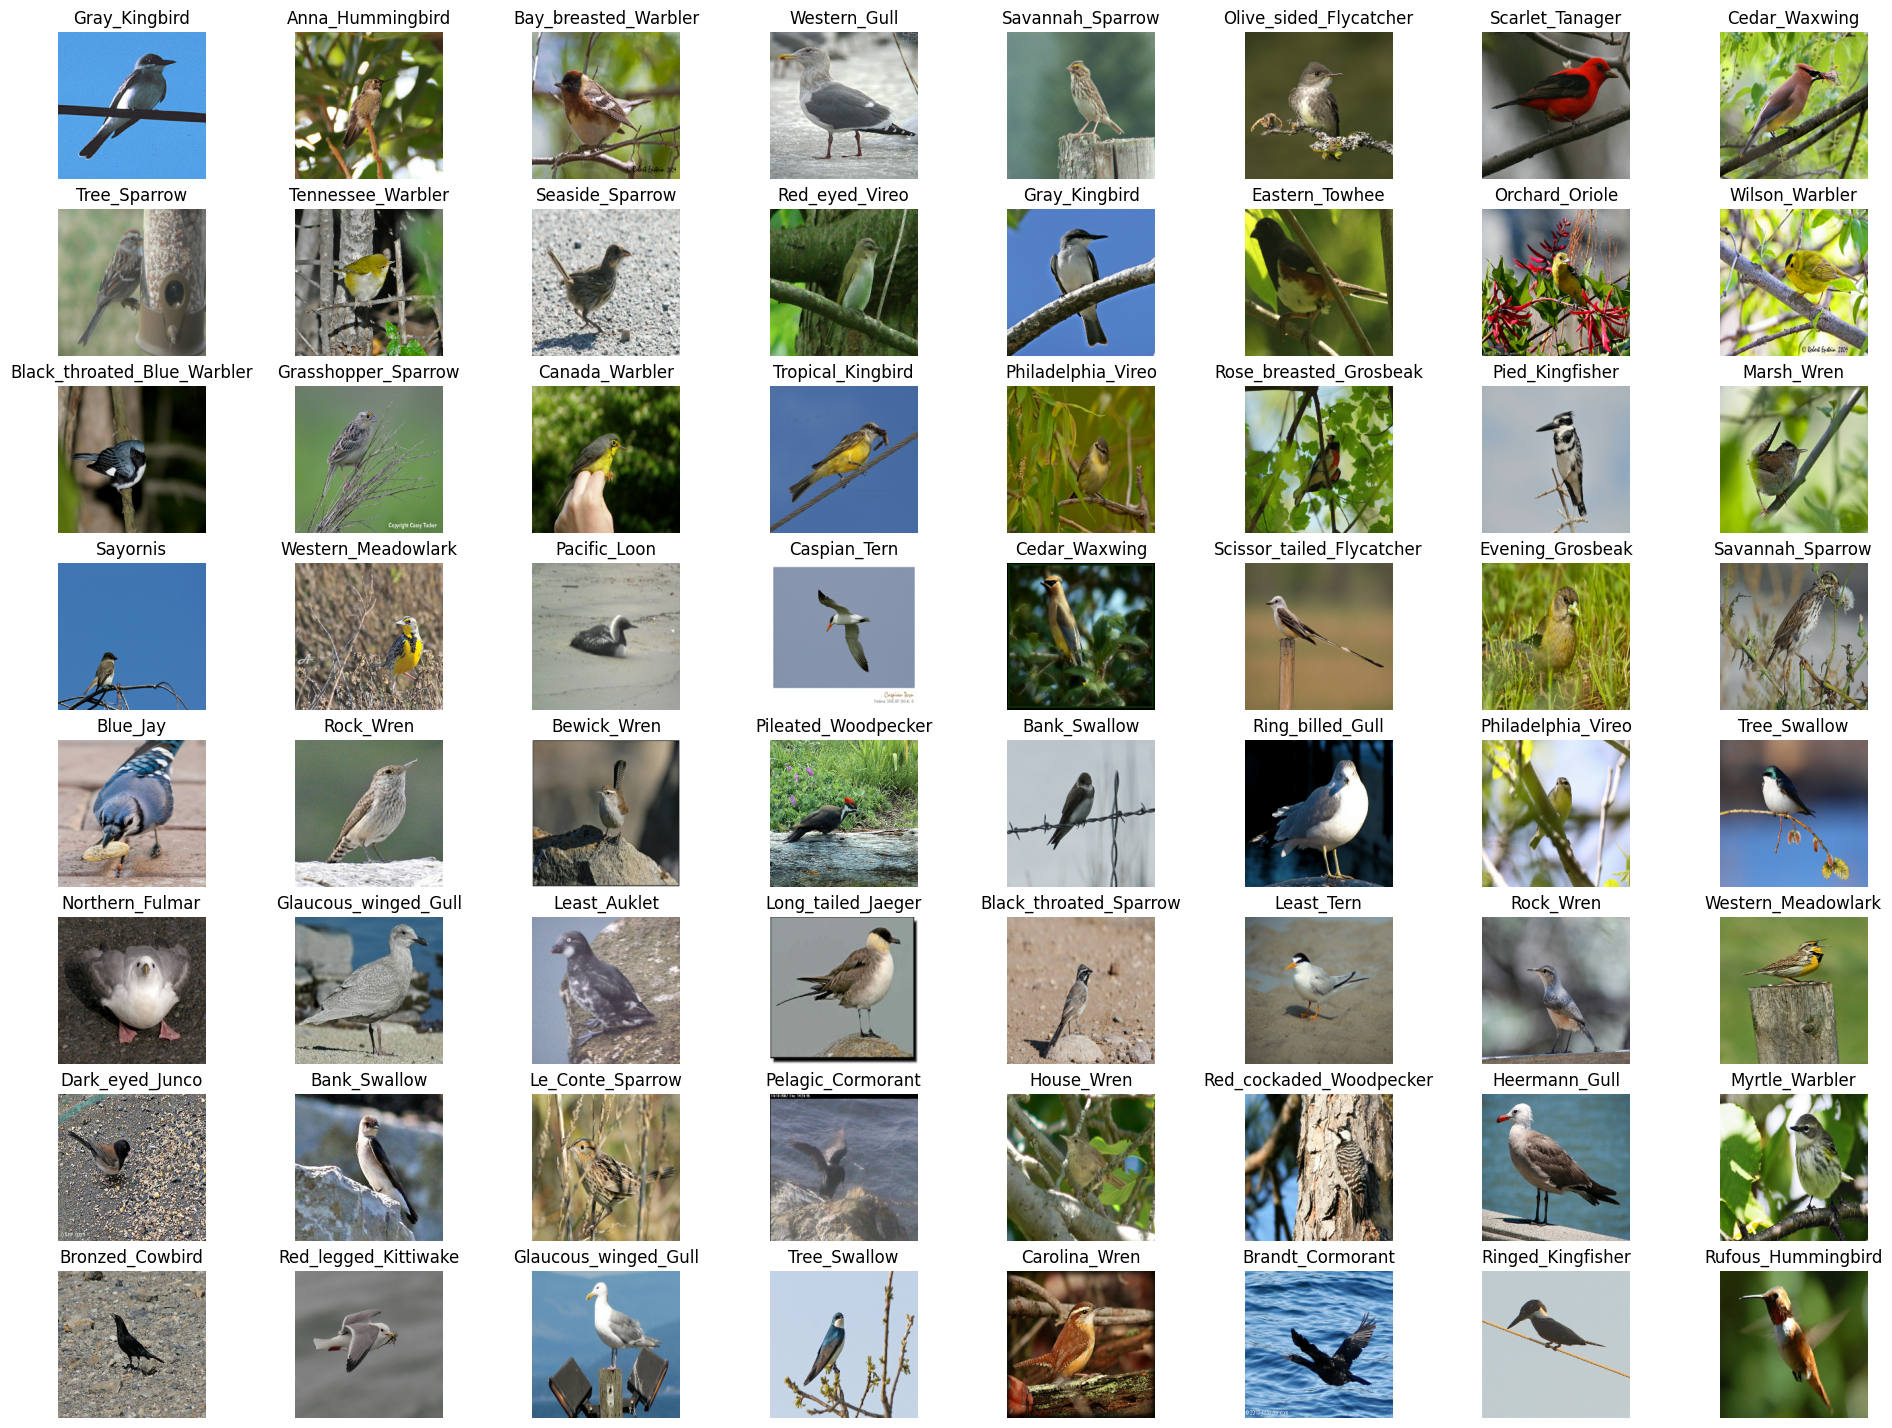

In [9]:
visualize_dataset(train_ds) #Yukardaki yazdığım fonksiyonu çağırıyorum.

ANN TARZI MODEL

In [19]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(224, 224, 3)), # Giriş katmanıdır.(224, 224, 3) boyutundaki 3D görüntüyü alır ve onu
    #224*224*3 = 150,528 elemanlı tek boyutlu düz bir liste(vektöre) çevirir.
    
    tf.keras.layers.Dense(200, activation='relu'), # Gizli katman. 128 nöron içerir. "relu" aktivasyonu, modelin karmaşık kalıpları öğrenmesini sağlar.

    tf.keras.layers.Dense(total_classes, activation='softmax') # Çıkış Katmanı. Nöron sayısı, sınıf sayımıza (total_classes = 200) eşit olmalıdır.
    #"softmax" aktivasyonu,200 sınıf için olasılıkları hesaplar. Sigmoid aktivasyonu da vardır. Sigmoid aktivasyonu evet/hayır cevapı yani tek cevap verir.
    #softmax ise bu resim kedi mi? kuş mu? timsah mı? gibi çoktan seçmeli sorulara cevap verir.
])

C:\Users\reybe\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(
    loss='sparse_categorical_crossentropy', # Loss metotu = Modelin ne kadar yanlış olduğunu hesaplayacak.
    #sparse_categorical_crossentropy kullanıyoruz. Categorical= veri setinin etiketli olduğu için.
    #crossentropy ise label_mode=int yaptığımız için kullandık. Bu metot gerçek etiketlerin integer olmasını bekler.
    
    optimizer='adam', #Modelin kendini nasıl düzelteceğini belirler. En çok kullanılan verimli olarak görülen adam optimize edicisidir.
    #Algoritma olarak düşünebiliriz.
    
    metrics=['accuracy'] #Metrics= Eğiitm sırasında neyi takip etmek istediğimiz. Accuary yani doğruluk oranını görmek istiyorum
)

model.summary() #Model'in özeti.

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 200)            │    30,105,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 200)            │        40,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,146,000 (115.00 MB)

 Trainable params: 30,146,000 (115.00 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit( #Model.fit modelin öğrenmeye başlamasını sağlar. epoch ise döngü sayısıdır. daha iyi bir sonuç için arttırılabilir.
    train_ds,
    validation_data=valid_ds,
    epochs=10
)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 8s 97ms/step - accuracy: 0.0051 - loss: 6937.0166 - val_accuracy: 0.0051 - val_loss: 5.2983
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.0031 - loss: 5.3004 - val_accuracy: 0.0051 - val_loss: 5.2982
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 93ms/step - accuracy: 0.0039 - loss: 5.2985 - val_accuracy: 0.0051 - val_loss: 5.2981
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 7s 95ms/step - accuracy: 0.0046 - loss: 5.2984 - val_accuracy: 0.0051 - val_loss: 5.2980
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 24s 330ms/step - accuracy: 0.0045 - loss: 5.2983 - val_accuracy: 0.0051 - val_loss: 5.2980
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 48s 427ms/step - accuracy: 0.0046 - loss: 5.2982 - val_accuracy: 0.0051 - val_loss: 5.2979
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 32s 436ms/step - accuracy: 0.0046 - loss: 5.2982 - val_accuracy: 0.0051 - val_loss: 5.2979
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 38s 396ms/step - accuracy: 0.0047 - loss: 5.2981 - val_accuracy:

CNN TARZI MODEL

In [10]:
cnn_model = tf.keras.Sequential([ # Sequential = sıralı.
    
    tf.keras.layers.Rescaling(1./255, input_shape=(image_size[0], image_size[1], 3)), #Görüntüleri 0-255 piksel aralığından 0-1 aralığına indirger.
    #Modelin daha hızlı çalışması için eklenebilirmiş.
    
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu'), #32 filtre kullanarak resimdeki "kenar" ve "eğri" gibi temel desenleri arar.
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'), #64 filtre kullanarak ilk bloktan gelen basit desenleri birleştirir.
    #örn: "göz", "gaga" gibi daha karmaşık şekilleri arar.
    tf.keras.layers.MaxPooling2D(),
    
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),# 128 filtre ile daha da karmaşık özellikleri (örn: "tüy deseni") arar.
    tf.keras.layers.MaxPooling2D(),

    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(256, activation='relu'),
    
    tf.keras.layers.Dense(total_classes, activation='softmax')
])

C:\Users\reybe\AppData\Roaming\Python\Python313\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [11]:
cnn_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 200)            │        51,400 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,296,072 (85.05 MB)

 Trainable params: 22,296,072 (85.05 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = cnn_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=30
)

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 175s 2s/step - accuracy: 0.9059 - loss: 0.3858 - val_accuracy: 0.0691 - val_loss: 12.1602
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 58s 782ms/step - accuracy: 0.9370 - loss: 0.2594 - val_accuracy: 0.0691 - val_loss: 12.3056
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.9572 - loss: 0.1819 - val_accuracy: 0.0699 - val_loss: 13.9258
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 53s 719ms/step - accuracy: 0.9640 - loss: 0.1428 - val_accuracy: 0.0674 - val_loss: 14.6245
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 53s 724ms/step - accuracy: 0.9746 - loss: 0.1085 - val_accuracy: 0.0682 - val_loss: 15.5618
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 54s 729ms/step - accuracy: 0.9783 - loss: 0.0923 - val_accuracy: 0.0699 - val_loss: 15.4026
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 54s 728ms/step - accuracy: 0.9856 - loss: 0.0751 - val_accuracy: 0.0729 - val_loss: 15.3706
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 55s 741ms/step - accuracy: 0.9859 - loss: 0.0618 - val_a

CNN Model ile Kuş Sınıfını Bulma(Önce yukarıdaki CNN modeli çalıştırmamız lazım.)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


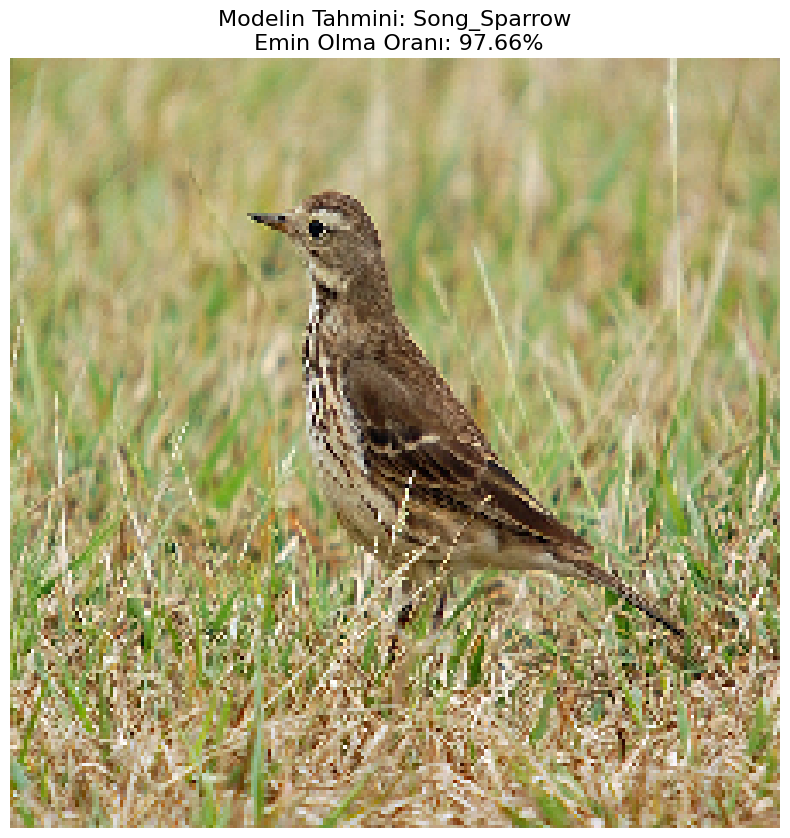

Yüklenen Resim: C:/Users/reybe/Desktop/staj/bird/Test/American_Pipit/American_Pipit_0017_99902.jpg
Modelin Tahmini: Song_Sparrow
Emin Olma Oranı: 97.66%


In [ ]:
import numpy as np #Numpy hızlı çalışan dizilerdir. Python dizileri yerine bu dizileri kullanırız.
from tensorflow.keras.utils import load_img, img_to_array

image_path = "C:/Users/reybe/Desktop/staj/bird/Test/American_Pipit/American_Pipit_0017_99902.jpg" 

img = load_img(image_path, target_size=image_size) #Resmi diskten yükler ve modelin eğitildiği boyuta (224x224) getirir.

img_array = img_to_array(img) #Resmi bir NumPy dizisine çevirir.(shape: 224, 224, 3) Burdaki 3 renk kanalları sayısıdır.(red-blue-green). Değerler henüz 0-255 aralığında.

img_batch = tf.expand_dims(img_array, 0) #Model, tek bir resim yerine "batch" (grup) bekler. Resmin başına 1'lik bir batch boyutu ekliyoruz (shape: 1, 224, 224, 3)

#Burada tf.keras.layers.Rescaling(1./255) kullanmamız gerekir ama CNN modeli tanımlarken yapmıştık zaten.

predictions = cnn_model.predict(img_batch) #Eğitilmiş CNN Modeli kullanarak tahmini yap.

probabilities = predictions[0] #Olasılıkları al(örn: [0.01, 0.05, 0.85 gibi])

predicted_index = np.argmax(probabilities) #En yüksek olasılığa sahip olan index'i bul (0 ile 199 arası bir sayı)

predicted_class_name = classes[predicted_index] # Bu index'in hangi kuş türüne ait olduğunu 'classes' listemizden bulur.

confidence = np.max(probabilities) #Modelin bu tahmininden ne kadar "emin" olduğunu bulur.

plt.figure(figsize=(10, 10)) #Orijinal resmi çizdirmek için.
plt.imshow(img) #Orijinal resmi göstermek için img'yi kullanıyoruz
plt.title(f"Modelin Tahmini: {predicted_class_name}\n Emin Olma Oranı: {confidence * 100:.2f}%", fontsize=16)
plt.axis('off')
plt.show()

print(f"Yüklenen Resim: {image_path}") #Burada da metin olarak görmek için.
print(f"Modelin Tahmini: {predicted_class_name}")
print(f"Emin Olma Oranı: {confidence * 100:.2f}%")

DenseNet121 Transfer Learning MODELİNİ EĞİTME

In [19]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Input, Dropout
from tensorflow.keras.models import Model

In [ ]:
#CNN Modeli yazarken Sequential kullanıyorduk. DenseNet121'de ise Input ve Outputs'ları kullanacağız.
#Çünkü preprocess_input fonksiyonunu modelin içine bir katman gibi yerleştirmemizi sağlayacak.
inputs = Input(shape=(image_size[0], image_size[1], 3))

#DenseNet121 modelinde resimleri 0-255 aralığında değil,ImageNet istatistiklerine göre normalize edilmiş (-1 ile 1 arası) bekler.
#Bu fonksiyon, 0-255 aralığındaki resimlerini modelin beklediği formata otomatik çevirir.
x = preprocess_input(inputs)

base_model = DenseNet121(
    weights='imagenet',     #ImageNet üzerinde eğitilmiş ağırlıkları(önemli kısımları) indir.
    include_top=False,      #Modelin içindeki 1000 tane sınıf olduğunu söylemiştik onları atmamızı sağlar.
    input_tensor=x          #Giriş olarak bizim ön-işlenmiş x katmanımızı kullan
)

#DenseNet121'in öğrendiği milyonlarca şeyi (kenar, doku vb.) eğitim sırasında bozmamasını sağlıyoruz.(Donduruyoruz diyebiliriz.)
base_model.trainable = False

#Yukarıda eğitim sırasında bozulmamasını sağladığımız modelin çıktısını al
x = base_model.output

#Bu kısma doğru kuş türünü bulmamızı kolaylaştıracak modelin ezber yapmasını engellemek için
#tf.keras.layers.RandomFlip("horizontal") eklenmeli.

#Çıktıyı düzleştir(Flatten yerine GlobalAveragePooling2D kullanmak istedim.)
x = GlobalAveragePooling2D()(x)

#Ezberlemeyi önlemek için bir Dropout katmanı ekledik. Bu fonksiyon nöronların %50'sini rastgele kapatarak modelin ezber yapmasını zorlaştıracak.
x = Dropout(0.5)(x)

x = Dense(256, activation='relu')(x)

outputs = Dense(total_classes, activation='softmax')(x) #200 kuş türümüz için 'softmax' çıkışı

transfer_model = Model(inputs, outputs) #Girişleri Ve Çıkışları Birleştirerek modeli oluşturduk.

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 15s 1us/step


In [ ]:
transfer_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

transfer_model.summary()

history_transfer = transfer_model.fit( #CNN modelimizde 10 epochta American_Pipit sınıfı bulamıyordu. Bakalım bu modelde bulabilecek mi?
    train_ds,
    validation_data=valid_ds,
    epochs=10
)

# İnce ayar yapıyoruz. ilk 10 döngü duracak sonrasında bir 10 döngü daha ekleyeceğiz.

#Aşağıda yazdığım 4 satır 10 döngülük ince ayar kısmı yine aradığımız kuş türünü bulamazsa diye
#yapabileceğimiz değişikliklerdir.

#Initial_epochs_compeleted = 10                           
#Epochs_to_add = 30
#total_epochs = Initial_epochs_compeleted + Epochs_to_add
#initial_epoch = Initial_epochs_completed

base_model.trainable = True #Modeli eğitirken göz kısmını dondurmuştuk sonradan eklediğimiz 10 epochta açalım.
#DenseNet121'in önceden öğrendiği verileri ekledik sayabiliriz.

transfer_model.summary() #Eğitilebilir (Trainable) parametre sayısının arttığını göreceğiz.
#İlk 10 döngüde eğitilemeyen parametre sayısı 7 milyondu. Eğittiği ise 300 bindi.

transfer_model.compile( #Modeli çok düşük bir öğrenme oranı ile yeniden derliyoruz. Modelin zaten öğrendiği iyi özellikleri(ImageNet) bozmadan sadece hafifçe ayarlamasını sağlar.
    loss='sparse_categorical_crossentropy',
    #Adam optimizer'a çok düşük bir öğrenme oranı veriyoruz.
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),# yaklaşık olarak 0.00001 verdik.
    metrics=['accuracy']
)

fine_tune_epochs = 10
total_epochs = 10 + fine_tune_epochs # (İlk 10 epoch + yeni 10 epoch)

history_fine_tune = transfer_model.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=total_epochs,           # Toplam epoch sayısına kadar devam et
    initial_epoch=history.epoch[-1] # Eğitime kaldığı yerden (10. epoch'tan) başla
)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 224, 224,  │          0 │ add[0][0]         │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ true_divide_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],    

 Total params: 7,351,304 (28.04 MB)

 Trainable params: 7,267,656 (27.72 MB)

 Non-trainable params: 83,648 (326.75 KB)

Epoch 1/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 786s 10s/step - accuracy: 0.4555 - loss: 2.0488 - val_accuracy: 0.1276 - val_loss: 8.7171
Epoch 2/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 789s 11s/step - accuracy: 0.6339 - loss: 1.2186 - val_accuracy: 0.4945 - val_loss: 2.1636
Epoch 3/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 791s 11s/step - accuracy: 0.7333 - loss: 0.8691 - val_accuracy: 0.5021 - val_loss: 1.9751
Epoch 4/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 790s 11s/step - accuracy: 0.7811 - loss: 0.6956 - val_accuracy: 0.5771 - val_loss: 1.8012
Epoch 5/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 791s 11s/step - accuracy: 0.8108 - loss: 0.6007 - val_accuracy: 0.4217 - val_loss: 2.5169
Epoch 6/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 787s 11s/step - accuracy: 0.8349 - loss: 0.5148 - val_accuracy: 0.5910 - val_loss: 1.6520
Epoch 7/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 788s 11s/step - accuracy: 0.8557 - loss: 0.4328 - val_accuracy: 0.6074 - val_loss: 1.7867
Epoch 8/10
74/74 ━━━━━━━━━━━━━━━━━━━━ 784s 11s/step - accuracy: 0.8894 - loss: 0.3352 - val_accuracy: 0.

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide         │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 224, 224,  │          0 │ true_divide[0][0] │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_1       │ (None, 224, 224,  │          0 │ add[0][0]         │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ true_divide_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],    

 Total params: 21,886,618 (83.49 MB)

 Trainable params: 7,267,656 (27.72 MB)

 Non-trainable params: 83,648 (326.75 KB)

 Optimizer params: 14,535,314 (55.45 MB)

Epoch 30/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 811s 11s/step - accuracy: 0.9329 - loss: 0.2085 - val_accuracy: 0.7190 - val_loss: 1.1571
Epoch 31/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 785s 11s/step - accuracy: 0.9536 - loss: 0.1541 - val_accuracy: 0.7473 - val_loss: 1.0453
Epoch 32/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 786s 11s/step - accuracy: 0.9604 - loss: 0.1247 - val_accuracy: 0.7578 - val_loss: 1.0117
Epoch 33/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 787s 11s/step - accuracy: 0.9683 - loss: 0.1090 - val_accuracy: 0.7641 - val_loss: 0.9854
Epoch 34/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 789s 11s/step - accuracy: 0.9727 - loss: 0.0921 - val_accuracy: 0.7683 - val_loss: 0.9741
Epoch 35/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 788s 11s/step - accuracy: 0.9776 - loss: 0.0823 - val_accuracy: 0.7730 - val_loss: 0.9618
Epoch 36/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 786s 11s/step - accuracy: 0.9798 - loss: 0.0727 - val_accuracy: 0.7755 - val_loss: 0.9537
Epoch 37/40
74/74 ━━━━━━━━━━━━━━━━━━━━ 785s 11s/step - accuracy: 0.9824 - loss: 0.0661 - val_accu

DenseNet121 Transfer Learning ile aradığımız kuş türünü bulma.

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


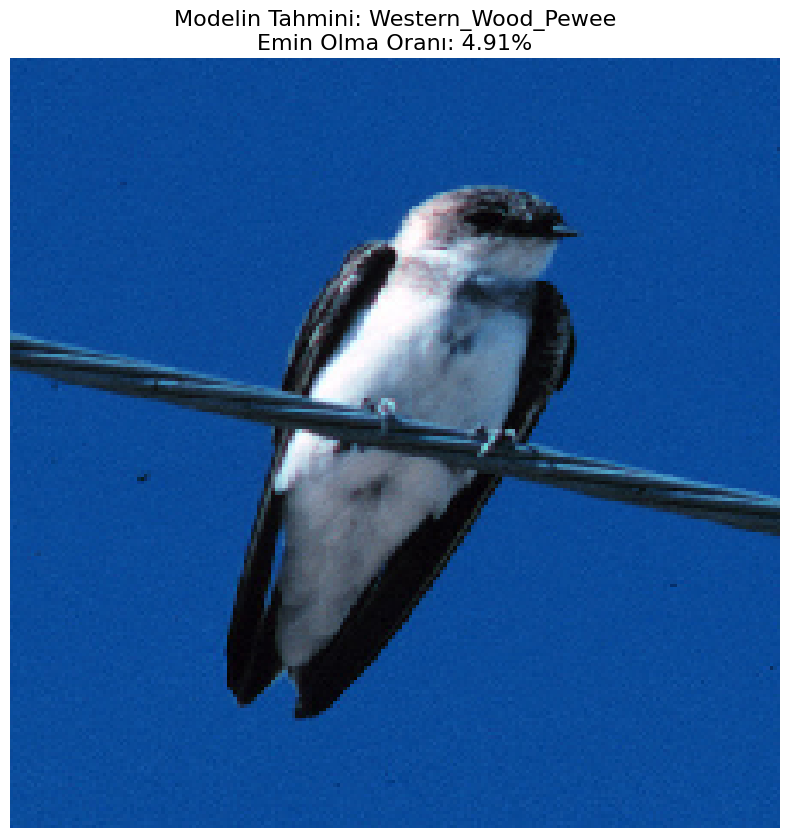

Yüklenen Resim: C:/Users/reybe/Desktop/staj/bird/Test/Bank_Swallow/Bank_Swallow_0003_129623.jpg
Modelin Tahmini: Western_Wood_Pewee
Emin Olma Oranı: 4.91%


In [31]:
import numpy as np
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.applications.densenet import preprocess_input

image_path = "C:/Users/reybe/Desktop/staj/bird/Test/Bank_Swallow/Bank_Swallow_0003_129623.jpg"

img = load_img(image_path, target_size=image_size)

img_array = img_to_array(img)

img_batch = tf.expand_dims(img_array, 0)

#Resmi DenseNet121'in beklediği formata (-1 ile 1) normalize et. Rescaling(1./255)'ten farklıdır.
img_preprocessed = preprocess_input(img_batch)

predictions = transfer_model.predict(img_preprocessed)

probabilities = predictions[0]

predicted_index = np.argmax(probabilities)

predicted_class_name = classes[predicted_index]

confidence = np.max(probabilities)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title(f"Modelin Tahmini: {predicted_class_name}\nEmin Olma Oranı: {confidence * 100:.2f}%", fontsize=16)
plt.axis('off')
plt.show()

print(f"Yüklenen Resim: {image_path}")
print(f"Modelin Tahmini: {predicted_class_name}")
print(f"Emin Olma Oranı: {confidence * 100:.2f}%")
